<a href="https://colab.research.google.com/github/LidaDavydova/MelanomaVenusClassification/blob/main/testModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import PIL
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from sklearn.utils import Bunch
import pickle

2024-08-17 20:26:33.392375: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-17 20:26:33.393992: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-17 20:26:33.422056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 20:26:33.422088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 20:26:33.423044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

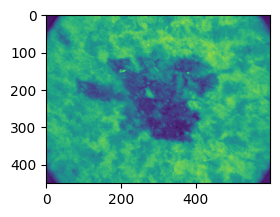

In [2]:
# upload img
img_path = 'dataset/test/melanoma/ISIC_0024310.jpg' # измени на путь к своему изображению (вроде работает для png и jpg формата)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.subplot(2,2,2)
plt.imshow(image)

In [9]:
# upload model
model = tf.keras.models.load_model('models/model_keras_2_1.keras') # измени на свой путь к модели .keras/.h5

In [10]:
image = keras.utils.load_img(img_path, target_size=(224,224))
input_arr = keras.utils.img_to_array(image)
input_arr = np.array([input_arr])

In [11]:
pred = model.predict(input_arr)
pred2 = pred.tolist()[0]
diff = abs(pred2[0]-pred2[1])
pred, diff

1/1 [==============================] - 0s 49ms/step


(array([[ 0.40251198, -0.27879876]], dtype=float32), 0.6813107430934906)

In [13]:
range_len = 5.0
min_el = 8.369982242584229e-05

In [15]:
precis = (diff-min_el)/range_len

In [19]:
classes = {0: 'melanoma', 1: 'nevus'}
cls = tf.argmax(pred, axis=1)
print(f"На {round(precis*100, 2)}% модель уверенна, что на изображении {classes[int(cls)]}")

На 13.62% модель уверенна, что на изображении melanoma


In [20]:
def load_my_fancy_dataset(df):
    data = []
    target = []
    for i, row in df.iterrows():
        lst = row.tolist()
        features = lst[:-1]
        label = lst[-1]
        data.append([float(num) for num in features])
        target.append(int(label))
    
    data = np.array(data)
    target = np.array(target)
    return Bunch(data=data, target=target, feature_names=df.columns[:-1])

In [21]:
localization_dict_val = {
    'lower extremity': 0, 
    'torso': 1, 
    'upper extremity': 2, 
    'head/neck': 3,
    'unknown': 4, 
    'palms/soles': 5, 
    'oral/genital': 6, 
    'scalp': 7, 
    'ear': 8, 
    'face': 9,
    'back': 10, 
    'trunk': 11, 
    'chest': 12, 
    'abdomen': 13, 
    'genital': 6, 
    'neck': 14, 
    'hand': 15,
    'foot': 16, 
    'acral': 17
}

In [30]:
sex = 'female'
age = 5
localization = 'hand'

In [31]:
target = 0 if cls == 1 else 1 # because of error while model fitting
features = pd.DataFrame([{
    'advantage': diff,
    'sex': sex,
    'age': age,
    'localization': localization,
    'target': target
}])
features.localization = features.localization.map(localization_dict_val)
features.sex = features.sex.map({'male': 0, 'female': 1})
features = load_my_fancy_dataset(features)

In [32]:
features.target

array([1])

In [33]:
# load
with open('models/model_sklearn_1_0.pkl', 'rb') as f:
    gb = pickle.load(f)

In [34]:
y_pred_gb = gb.predict(features.data)
y_pred_gb

array([0])

In [39]:
classes_for_2_model = {1: 'melanoma', 0: 'nevus'}

In [48]:
if features.target == y_pred_gb:
    if features.target == 1:
        print("melanoma")
    else:
        print("nevus")
else:
    print(f"1 модель рапознала {classes[int(cls)]}, 2 модель (на основе данных из первой) определила {classes_for_2_model[int(y_pred_gb[0])]}")

print(f"1 модель уверенна на {round(precis*100, 2)}%, что на изображении {classes[int(cls)]}")

1 модель рапознала melanoma, 2 модель (на основе данных из первой) определила nevus
1 модель уверенна на 13.62%, что на изображении melanoma
